# Grupo 09
## MINE4201- SR -  Laboratorio 1 
## Exploración modelos KNN

Librerías requeridas para despliegue en máquina personal.

In [106]:
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random
import seaborn as sns
from scipy.stats import norm

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

Modificamos código, bases de datos en disco local.

In [19]:
ratings=pd.read_csv('u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [20]:
items=pd.read_csv('u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1' )

/var/folders/vc/bv3v1b7126ng926zjj9gm01w0000gp/T/ipykernel_75786/2334481440.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  items=pd.read_csv('u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',


Verifique que los ratings y los items hayan sido cargados correctamente





In [21]:
#ratings.rating=ratings.rating.astype('category')
print(ratings.dtypes)

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object


In [22]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
items.dtypes

movie id                int64
movie title            object
release date           object
video release date    float64
IMDb URL               object
unknown                 int64
Action                  int64
Adventure               int64
Animation               int64
Children                int64
Comedy                  int64
Crime                   int64
Documentary             int64
Drama                   int64
Fantasy                 int64
Film-Noir               int64
Horror                  int64
Musical                 int64
Mystery                 int64
Romance                 int64
Sci-Fi                  int64
Thriller                int64
War                     int64
Western                 int64
dtype: object

In [24]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
ratings.value_counts()

user_id  item_id  rating  timestamp
1        1        5       874965758    1
606      91       5       880926610    1
         144      4       880924664    1
         138      3       880927923    1
         135      5       880926245    1
                                      ..
311      747      3       884364502    1
         739      4       884365823    1
         735      4       884366637    1
         732      4       884365617    1
943      1330     3       888692465    1
Length: 100000, dtype: int64

In [26]:
print(ratings.item_id.value_counts().tail(141))
print('-----')
print(len(ratings.item_id.value_counts()))

1673    1
599     1
1648    1
1309    1
1581    1
       ..
852     1
1505    1
1653    1
1452    1
1641    1
Name: item_id, Length: 141, dtype: int64
-----
1682


En ratings encontramos 943 usuarios con id único, que han generado 100,000 calificaciones para 1682 ítems (películas) distintos, de las cuales los 5 primeros acumulan cerca de 500 calificaciones o más, mientras que los 143 últimos sólo cuentan con 1 rating. 

## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

<AxesSubplot: >

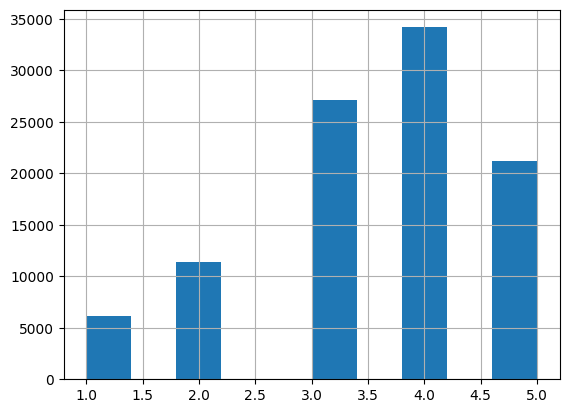

In [27]:
ratings.rating.hist()

<AxesSubplot: xlabel='rating', ylabel='Probability'>

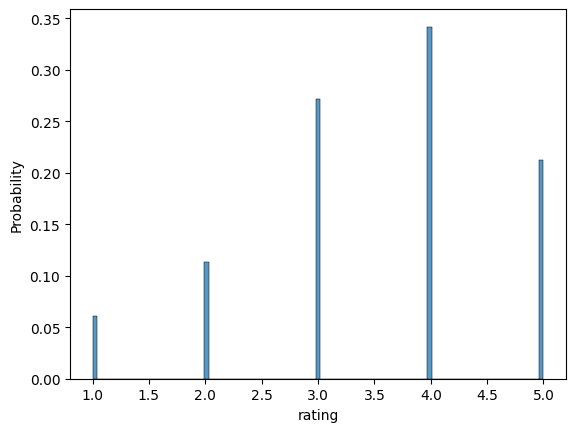

In [28]:
sns.histplot(ratings.rating, stat='probability', )

La distribución de los ratings está sesgada hacia la derecha. Esto indica que aproximadamente el 80% de los ratings ha sido igual o superior a 3. Esto nos indica que los items calificados suelen ser mejor recibidos por los usuarios. Una hipótesis para explicar esto es que los usuarios suelen ver películas que intuitivamente creen que van a ser de su agrado o que, precisamente, su elección de consumo está influenciada por una recomendación ya sea voz a voz, o a través de un algoritmo. Otra hipótesis podría ser que los usuarios suelen calificar con más frecuencia aquellos items que en efecto fueron de su agrado. 

## En la siguiente celda se esta calculando el número de ratings por usuario y  el promedio de sus calificaciones, el dataframe esta ordenado por el número de calificaciones

In [29]:
ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False)

,count,mean
user_id,,
405,737,1.834464
655,685,2.908029
13,636,3.097484
450,540,3.864815
276,518,3.465251
...,...,...
685,20,2.050000
475,20,3.600000
36,20,3.800000


In [30]:
ratings.groupby('user_id')['rating'].mean().reset_index()

,user_id,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


array([[<AxesSubplot: title={'center': 'count'}>,
        <AxesSubplot: title={'center': 'mean'}>]], dtype=object)

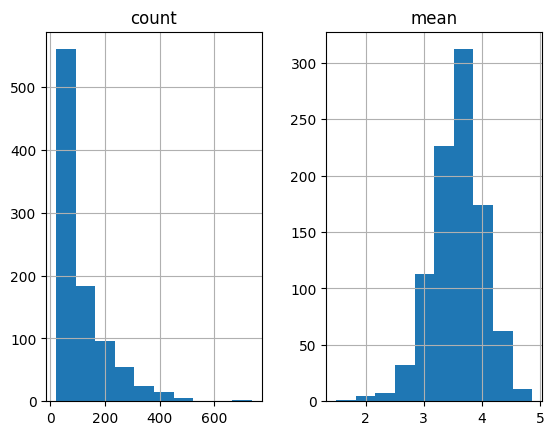

In [55]:
ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False).hist()

## Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

- ¿Cómo es la distribución del número de ratings por usuario?

- ¿Cómo es la distribución del promedio de calificación por usuario?


El número de ratings que otorga cada usuario muestra una ‘cola’ larga, lo que nos indica que la mayoría de los usuarios califica en promedio entre 20 y 100 veces (la cola está truncada a la izquierda ya que se excluyen usuarios con menos de 20 calificaciones) y hay unos pocos usuarios que califican más de 500 veces. 

Cuando examinamos el rating promedio otorgado por cada usuario, vemos una distribución de estos ratings más normalizada, centrada entre 3.5 y 4.0. 

## En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones. 

In [31]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

,var,count,mean,movie title
item_id,,,,
1,0.860992,452,3.878319,GoldenEye (1995)
2,0.934116,131,3.206107,Four Rooms (1995)
3,1.470787,90,3.033333,Get Shorty (1995)
4,0.931358,209,3.550239,Copycat (1995)
5,0.895759,86,3.302326,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,NaN,1,1.000000,B. Monkey (1998)
1679,NaN,1,3.000000,Sliding Doors (1998)
1680,NaN,1,2.000000,You So Crazy (1994)


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?  

¿Se puede observar el fenomeno de cola larga en este dataset?




In [32]:
mt=ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

In [33]:
mt

,var,count,mean,movie title
item_id,,,,
1,0.860992,452,3.878319,GoldenEye (1995)
2,0.934116,131,3.206107,Four Rooms (1995)
3,1.470787,90,3.033333,Get Shorty (1995)
4,0.931358,209,3.550239,Copycat (1995)
5,0.895759,86,3.302326,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,NaN,1,1.000000,B. Monkey (1998)
1679,NaN,1,3.000000,Sliding Doors (1998)
1680,NaN,1,2.000000,You So Crazy (1994)


<AxesSubplot: >

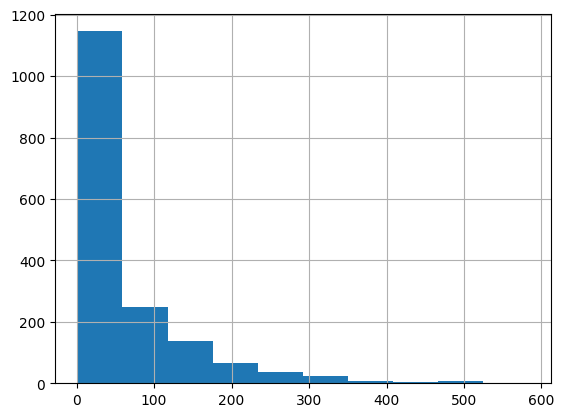

In [57]:
mt['count'].hist()

In [58]:
mt.sort_values(by='count', ascending=False)

,var,count,mean,movie title
item_id,,,,
50,0.776762,583,4.358491,Legends of the Fall (1994)
258,0.988885,509,3.803536,George of the Jungle (1997)
100,0.952100,508,4.155512,Heavy Metal (1981)
181,0.853693,507,4.007890,GoodFellas (1990)
294,1.206799,485,3.156701,Breakdown (1997)
...,...,...,...,...
1576,NaN,1,1.000000,"Death in the Garden (Mort en ce jardin, La) (1..."
1577,NaN,1,1.000000,"Collectionneuse, La (1967)"
1348,NaN,1,1.000000,Mille bolle blu (1993)


In [84]:
# ratings acumulados para el top x
def ratings_del_topx_items(x):
    cum = mt['count'][0:x].sum()
    tot = mt['count'].sum()
    print('Top {0} items con más ratings acumulan {1} ratings, o {2:%} del total'.format(x, cum, cum/tot))
    print(mt['count'][0:x])


In [85]:
ratings_del_topx_items(4)

Top 4 items con más ratings acumulan 882 ratings, o 0.882000% del total
item_id
1    452
2    131
3     90
4    209
Name: count, dtype: int64


In [86]:
ratings_del_topx_items(100)

Top 100 items con más ratings acumulan 14892 ratings, o 14.892000% del total
item_id
1      452
2      131
3       90
4      209
5       86
      ... 
96     295
97     256
98     390
99     172
100    508
Name: count, Length: 100, dtype: int64


In [87]:
ratings_del_topx_items(300)

Top 300 items con más ratings acumulan 47063 ratings, o 47.063000% del total
item_id
1      452
2      131
3       90
4      209
5       86
      ... 
296      6
297     50
298    194
299     73
300    431
Name: count, Length: 300, dtype: int64


Finalmente, observamos que los items con más calificaciones (Legends of the Fall, George of the Jungle, Heavy Metal, GoodFellas y Breakdown) son los más calificados y acumulan un total de 2592 calificaciones. El top-100 de items, acumula cerca del 15% de las calificaciones en el dataset y el top-300, cerca del 47%, por lo que claramente se evidencia el efecto de cola larga. 

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?

Ver: 

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


Generamos una lista de 10 recomendaciones no personalizadas, basada únicamente en el promedio de la calificación otorgada a los items, tal como se presenta a continuación: 

In [88]:
list_no_per = mt.sort_values(by='mean', ascending=False)
list_no_per.pop('var')
list_no_per[0:10].sort_values(by='count', ascending=False)

,count,mean,movie title
item_id,,,
1293,3,5.0,Ayn Rand: A Sense of Life (1997)
1189,3,5.0,That Old Feeling (1997)
1500,2,5.0,Prisoner of the Mountains (Kavkazsky Plennik) ...
1467,2,5.0,"Cure, The (1995)"
814,1,5.0,One Fine Day (1996)
1599,1,5.0,Guantanamera (1994)
1201,1,5.0,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)"
1122,1,5.0,"Last Time I Saw Paris, The (1954)"
1653,1,5.0,Chairman of the Board (1998)


Esta aproximación no funciona bien cuando existen ítems con pocas calificaciones1 (o una única) ya que no se puede evidenciar que la calificación sobre la que se basa la recomendación sea significativa, tal como se evidencia en la lista presentada anteriormente. 

Para corregir esto, calculamos el límite inferior (al 95% de confianza) de la calificación de cada una de las películas usando el score Wilson para un parámetro de Bernoulli. Para ello, clasificamos ‘ratings positivos’ como aquellos mayores a 3 y calculamos el parámetro usando la suma de estos ‘ratings positivos’ sobre el total de las calificaciones para cada item.

In [89]:
r_pos = ratings.copy()
r_pos

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [92]:
# Define función ratings 'positivos'
# Positivos son aquellos con rating > a 3.
funcion_pos = lambda x : True if x > 3 else False
r_pos['pos'] = ratings.rating.apply(funcion_pos)
r_pos

,user_id,item_id,rating,timestamp,pos
0,196,242,3,881250949,False
1,186,302,3,891717742,False
2,22,377,1,878887116,False
3,244,51,2,880606923,False
4,166,346,1,886397596,False
...,...,...,...,...,...
99995,880,476,3,880175444,False
99996,716,204,5,879795543,True
99997,276,1090,1,874795795,False
99998,13,225,2,882399156,False


In [98]:
# revisa función ratings positivos
r_pos.pos.describe()

count     100000
unique         2
top         True
freq       55375
Name: pos, dtype: object

In [104]:
r_pos_sum = r_pos.groupby('item_id')['pos'].sum()
new_mt = ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(r_pos_sum, how='left')
new_mt

,var,count,mean,pos
item_id,,,,
1,0.860992,452,3.878319,321
2,0.934116,131,3.206107,51
3,1.470787,90,3.033333,34
4,0.931358,209,3.550239,122
5,0.895759,86,3.302326,39
...,...,...,...,...
1678,NaN,1,1.000000,0
1679,NaN,1,3.000000,0
1680,NaN,1,2.000000,0


In [105]:
new_mt = new_mt.join(items['movie title'], how='left')
new_mt

,var,count,mean,pos,movie title
item_id,,,,,
1,0.860992,452,3.878319,321,GoldenEye (1995)
2,0.934116,131,3.206107,51,Four Rooms (1995)
3,1.470787,90,3.033333,34,Get Shorty (1995)
4,0.931358,209,3.550239,122,Copycat (1995)
5,0.895759,86,3.302326,39,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...,...
1678,NaN,1,1.000000,0,B. Monkey (1998)
1679,NaN,1,3.000000,0,Sliding Doors (1998)
1680,NaN,1,2.000000,0,You So Crazy (1994)


In [118]:
# define valor-z para intervalo de confianza
# asume distribución normal para los ratings
def valor_z_IC(val):
    dos_colas = (val/100)+(1-val/100)/2
    z = norm.ppf(dos_colas)
    return z

z = valor_z_IC(95)
print(z)

1.959963984540054


In [121]:
def calc_limite_inf_rating(r, conf=95):
    z = valor_z_IC(conf)
    n = r['count']
    phat = r['pos']/n
    a = phat*(1-phat)
    b = z**2/(4*n)
    sqrt = np.sqrt((a + b)/n)
    lb = (phat + z**2/(2*n) - z*sqrt)/(1 + z**2/n)
    return lb

La lista de recomendación, definida por el límite inferior del intervalo de confianza de la proporción de ratings positivos sobre el total de ratings al 95% es:

In [124]:
new_mt['lim_inf'] = new_mt.apply(calc_limite_inf_rating, axis=1)
new_mt.sort_values(by='lim_inf', ascending=False)[0:10]

,var,count,mean,pos,movie title,lim_inf
item_id,,,,,,
64,0.588302,283,4.445230,255,What's Eating Gilbert Grape (1993),0.860721
479,0.470153,179,4.251397,162,North by Northwest (1959),0.853180
318,0.687422,298,4.466443,265,Everyone Says I Love You (1996),0.848561
98,0.699895,390,4.289744,344,Snow White and the Seven Dwarfs (1937),0.846252
483,0.530150,243,4.456790,216,"Maltese Falcon, The (1941)",0.843167
603,0.507729,209,4.387560,185,It Happened One Night (1934),0.834824
427,0.547233,219,4.292237,193,Harold and Maude (1971),0.831731
50,0.776762,583,4.358491,501,Legends of the Fall (1994),0.828769
357,0.709284,264,4.291667,230,Spawn (1997),0.825421


# Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise. 

Para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [125]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [126]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [127]:
train_set.n_ratings

80000

In [128]:
len(test_set)

20000

In [129]:
#Este es el primer elemento del dataset de prueba (usuario 154, pelicula 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) 

El modelo recibe los siguientes parámetros: 


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [130]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [131]:
#Se le pasa la matriz de utilidad al algoritmo 
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [132]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False})

In [134]:
items[items['movie id']==302]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
301,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [138]:
ratings[(ratings['user_id'] == 154) & (ratings['item_id'] == 302)]

,user_id,item_id,rating,timestamp
2811,154,302,4,879138235


Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [43]:
test_predictions=algo.test(test_set)

In [44]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [45]:
# En promedio, el sistema encuentra ratings que estan una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

RMSE: 1.0453


1.0453343976192102

## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?

In [143]:
# definimos el modelo usuario usuario
sim_options = {'name': 'cosine',
               'user_based': True  # usuario-usuario vs item-based (anterior)
               }
algo_ub = KNNBasic(k=20, min_k=2, sim_options=sim_options)

# separamos set de entrenamiento y de test 80/20
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

#Se le pasa la matriz de utilidad al algoritmo 
algo_ub.fit(trainset=train_set)

pred = algo_ub.predict(154,302)

print('Predicción para el usuario 154, con la película 302\n', pred)
print('----------------')

# Calculamos predicción para todos los elementos en el test
test_predictions=algo_ub.test(test_set)
print('Primeras 5 predicciones:\n')
print(test_predictions[0:5])
print('----------------')

# Calculamos RMSE
rmse_ub = accuracy.rmse( test_predictions, verbose = True )
print('RSME usando modelo usuario-usuario:\n', rmse_ub)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Predicción para el usuario 154, con la película 302
 user: 154        item: 302        r_ui = None   est = 4.30   {'actual_k': 20, 'was_impossible': False}
----------------
Primeras 5 predicciones:

[Prediction(uid=666, iid=1154, r_ui=3.0, est=3.8593030365339347, details={'actual_k': 7, 'was_impossible': False}), Prediction(uid=536, iid=229, r_ui=4.0, est=3.6512974180857847, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=589, iid=289, r_ui=3.0, est=2.8495070635951065, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=72, iid=581, r_ui=4.0, est=3.649131751746577, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=796, iid=172, r_ui=4.0, est=4.501601225462762, details={'actual_k': 20, 'was_impossible': False})]
----------------
RMSE: 1.0263
RSME usando modelo usuario-usuario:
 1.0263210452409965


Con esto, observamos que el modelo "usuario-usuario" tiene un fit mejor que le modelo basado en items, dado que tenemos un RMSE de 1.026 vs 1.045.

El RMSE es el promedio de la raíz cuadrada de las varianzas de los residuos del modelo (siendo los residuos, la diferencia entre el valor de la predicción y el valor real). 

En este caso, el modelo usuario-usuario genera predicciones que en promedio se ajustan mejor a las calificaciones del usuario (i.e. un meno RMSE).

## Efectos de modificar el número de vecinos 'k' en la calidad del modelo usuario-usuario.

In [149]:
#Define función para iterar
def rmse_variando_k(ki):
    sim_options = {'name': 'cosine',
               'user_based': True  # usuario-usuario vs item-based (anterior)
               }
    algo_ub = KNNBasic(k=ki, min_k=2, sim_options=sim_options)
    train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)
    algo_ub.fit(trainset=train_set)
    test_predictions=algo_ub.test(test_set)
    rmse_ub = accuracy.rmse( test_predictions, verbose = True )
    return rmse_ub

In [160]:
ls_k = [k for k in range(5, 40 ,5)]
ls_rsme = list()

for ki in ls_k:
    rsme = rmse_variando_k(ki)
    ls_rsme.append(rsme)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0829
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0423
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0313
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0227
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0174
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0185
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0224


<AxesSubplot: >

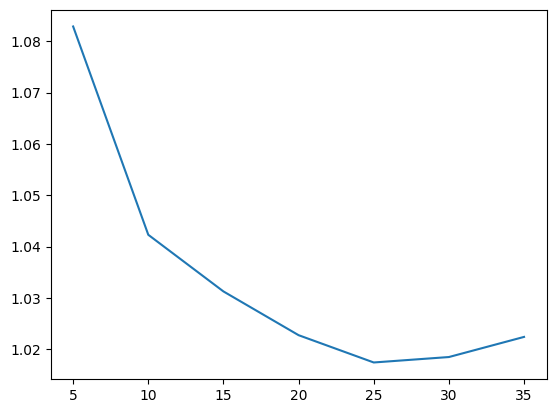

In [161]:
sns.lineplot(x=ls_k, y=ls_rsme)

## Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [46]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [47]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [48]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [49]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [50]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [51]:
user_predictions

[Prediction(uid=196, iid=1309, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1310, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1676, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1675, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1289, r_ui=3.52986, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1643, r_ui=3.52986, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1593, r_ui=3.52986, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=196, iid=935, r_ui=3.52986, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1216, r_ui=3.52986, est=4.0506920732628675, details={'actual_k': 20, 'was_i

In [52]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [53]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

In [54]:
ratings['user_id'].max()+1

944